In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from keras.applications import InceptionResNetV2

In [ ]:
import os
import shutil

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

In [ ]:
!unzip dogs-vs-cats.zip

In [ ]:
!unzip train.zip

In [ ]:
!unzip test1.zip

In [ ]:
# Path to the directory containing images
train_dir = '/content/train'

# Loop through files in the 'train' directory
for filename in os.listdir(train_dir):
    if 'cat' in filename:
      os.makedirs(os.path.join(train_dir, 'cats'),exist_ok=True)
      shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, 'cats', filename))
    elif 'dog' in filename:
      os.makedirs(os.path.join(train_dir, 'dogs'),exist_ok=True)
      shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, 'dogs', filename))

In [ ]:
# List to store image paths and corresponding labels (assuming binary classification)
image_paths = []
labels = []

# Loop through the directory to get image paths and labels
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    for image_file in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_file)
        image_paths.append(image_path)
        labels.append(label)  # Assuming directory names represent labels

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(image_paths,labels,random_state=28)
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,random_state=28)

In [ ]:
print(' Length of X_train:',len(X_train),'\t','y_train:',len(y_train),
      '\n','Length of X_valid:',len(X_valid),'\t','y_valid:',len(y_valid),
      '\n','Length of X_test:',len(X_test),'\t','y_test:',len(y_test))

 Length of X_train: 14062 	 y_train: 14062 
 Length of X_valid: 4688 	 y_valid: 4688 
 Length of X_test: 6250 	 y_test: 6250


In [ ]:
data = []  # Create an empty list to store the pairs

for x, y in zip(X_train, y_train):
    data.append((str(x), str(y)))

for path,label in data:
  formatted_path=path.ljust(40)
  print(f"{formatted_path}{label}")

In [ ]:
# Assuming X_train, X_valid, and X_test are lists of image paths
# and y_train, y_valid, and y_test are lists of corresponding labels

# Creating DataFrames from the lists
train_df = pd.DataFrame({'path': X_train, 'label': y_train})
valid_df = pd.DataFrame({'path': X_valid, 'label': y_valid})
test_df = pd.DataFrame({'path': X_test, 'label': y_test})

# Creating ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 14062 validated image filenames belonging to 2 classes.
Found 4688 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.


In [ ]:
model=keras.models.Sequential()

model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [ ]:
model_history=model.fit(train_generator,
                        steps_per_epoch=440,
                        epochs=100,
                        validation_data=valid_generator,
                        validation_steps=147)

In [ ]:
pd.DataFrame(model_history.history).plot(figsize=(7,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
predictions=model.evaluate(test_generator,steps=196)
predictions

In [ ]:
model.save('model_secondrun.h5')

In [ ]:
K.clear_session()
del model

##**Using transfer learning**

In [ ]:
conv_base=InceptionResNetV2(weights='imagenet',
                include_top=False,
                input_shape=(150,150,3))

In [ ]:
conv_base.summary()

In [ ]:
model=keras.models.Sequential()

model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

In [ ]:
checkpoint_cb=keras.callbacks.ModelCheckpoint('CNN-ProjectModel-{epoch:02d}.h5',save_best_only=True)

In [ ]:
model_history=model.fit(train_generator,
                        steps_per_epoch=440,
                        epochs=10,
                        validation_data=valid_generator,
                        validation_steps=147,
                        callbacks=[checkpoint_cb])

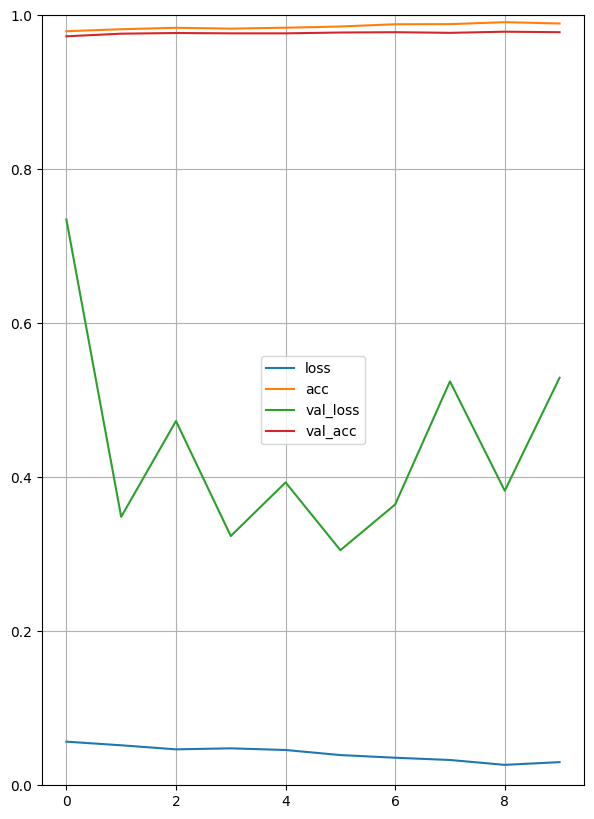

In [ ]:
pd.DataFrame(model_history.history).plot(figsize=(7,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
predictions=model.evaluate(test_generator,steps=196)
predictions

196/196 [==============================] - 17s 87ms/step - loss: 0.6445 - acc: 0.9765


[0.6445493102073669, 0.9764800071716309]